In [1]:
from pathlib import Path
import os

from eolearn.core import EOPatch
from eolearn.core import OverwritePermission, FeatureType
from eolearn.io import ExportToTiff
import sentinelhub

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
from numpy.random import default_rng
# import pandas as pd
# import seaborn as sn

from sklearn import metrics

from joblib import Parallel, delayed
import joblib

In [2]:
# load the model from disk
model = joblib.load('/home/AOIs/polyphytos/young_research_data/sen2cor/S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442/results/rf_model.sav')

In [3]:
fpath = '/home/AOIs/polyphytos/young_research_data/sen2cor/'
fname = 'from_miscellaneous/salo/S2L2A_20210420_unseen'
base_path = Path(fpath)/fname

In [4]:
eop = EOPatch.load(base_path)
feature_list = eop.meta_info['band_names']
eop

EOPatch(
  data: {
    Sentinel-2: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    band_names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    bands: 10
    height: 2564
    time: 1
    width: 3158
  }
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: [datetime.datetime(2021, 4, 20, 10, 0, 21)]
)

In [5]:
time, height, width, channels = eop.data['Sentinel-2'].shape

Create mask which you will apply after prediction in order to avoid visualizing noData values

In [6]:
# Fill NaN and Infinity values dues to VIBI calculation
mask = np.any(eop.data['Sentinel-2']==0, axis=3) | np.any(np.isnan(eop.data['Sentinel-2']), axis=3) | np.any(np.isinf(eop.data['Sentinel-2']), axis=3)
mask = np.transpose(mask, (1, 2, 0))
mask.shape

(2564, 3158, 1)

In [7]:
n_pixels = eop.data['Sentinel-2'].reshape(time*height*width, channels).shape[0]
n_pixels

8097112

In [8]:
for i in range(1, 1000):
    if n_pixels%i == 0:
        print(i)

1
2
4
8
641


In [9]:
n_cores = 32
parallel = Parallel(n_jobs=-1)
results = parallel(delayed(model.predict_proba)(np.split(eop.data['Sentinel-2'].reshape(time*height*width, channels), 641)[i]) for i in range(n_cores))
y_hat = np.vstack(results)
results[0].shape

(12632, 2)

In [10]:
y_hat = model.predict_proba(eop.data['Sentinel-2'].reshape(time*height*width, channels))
y_hat.shape

(8097112, 2)

In [11]:
# Default threshold for prediction probability (0.5)
y_hat_b = np.argmax(y_hat, axis=1)
y_hat_b.shape

(8097112,)

In [121]:
# custom threshold for prediction probability
y_hat_b = (y_hat[:, 1] > 0.6).astype(np.uint8)

In [12]:
y_hat_t = y_hat_b.reshape(time, height, width)
y_hat_t.shape

(1, 2564, 3158)

Text(0.5, 1.0, 'RF prediction')

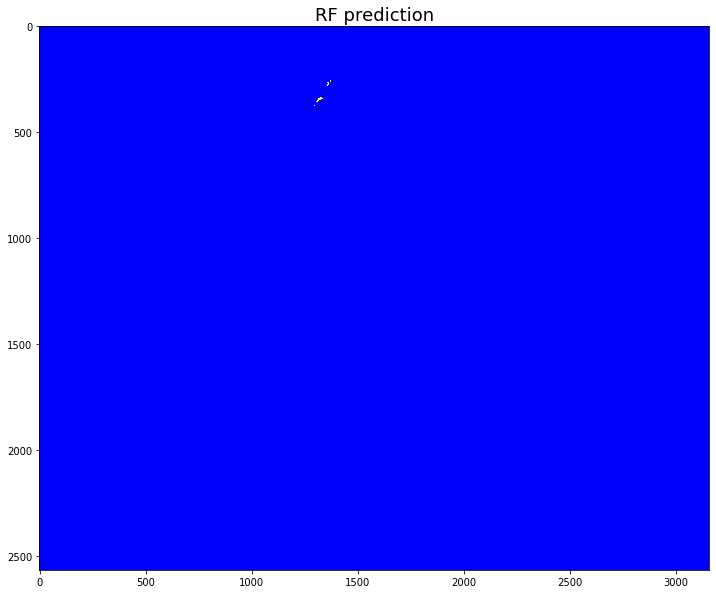

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
cmap = ListedColormap(['blue', 'yellow'])

ax.imshow(y_hat_t[0, ...], cmap=cmap)
ax.set_title('RF prediction', fontsize=18)

Text(0.5, 1.0, 'RF prediction probability')

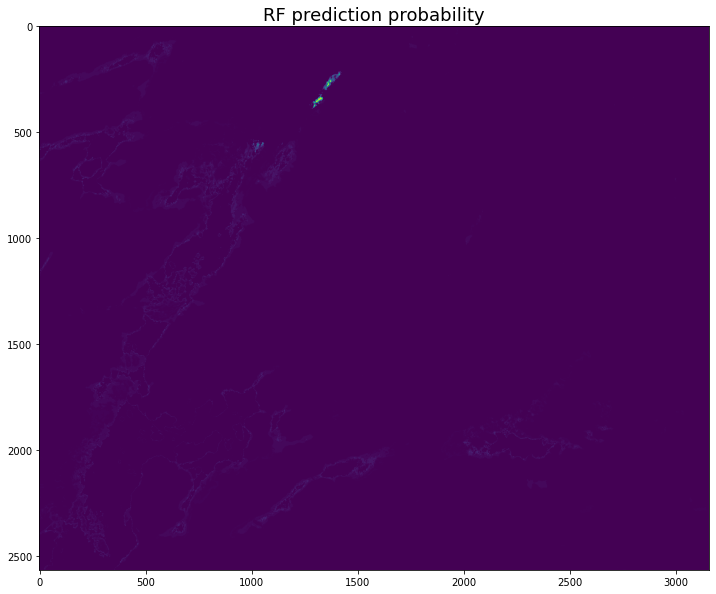

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
cmap = ListedColormap(['blue', 'yellow'])

ax.imshow(y_hat[:, 1].reshape(time, height, width)[0, ...])
ax.set_title('RF prediction probability', fontsize=18)

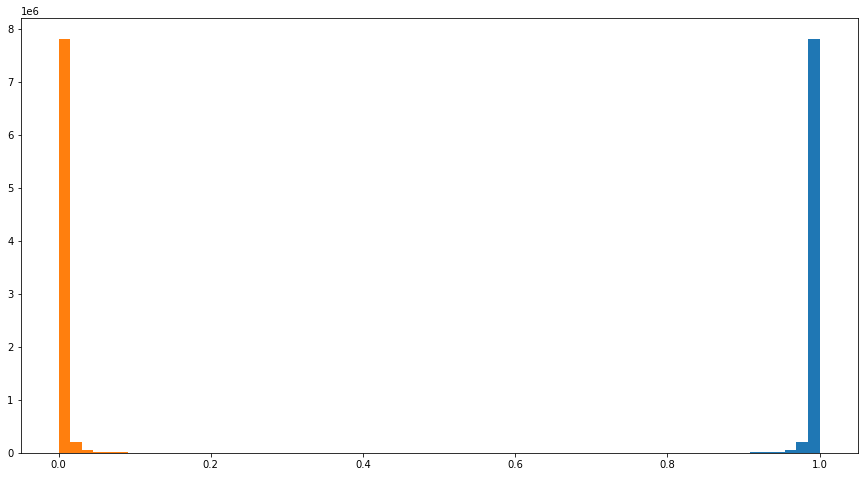

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(y_hat[:, 0], bins=50);
ax.hist(y_hat[:, 1], bins=50);
# ax.set_xscale('log')

In [16]:
eop.data_timeless['Muddy_water_pred'] = np.expand_dims(y_hat_t[0, ...].astype(np.uint8), axis=2)
eop.data_timeless['Muddy_water_proba'] = np.expand_dims(y_hat[:, 1].reshape(time, height, width)[0, ...].astype(np.float32), axis=2)

In [23]:
# Set noData values
eop.data_timeless['Muddy_water_pred'][mask] = 255
eop.data_timeless['Muddy_water_proba'][mask]= -9999

In [ ]:
# eop.bbox = sentinelhub.geometry.BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=sentinelhub.CRS('32632'))
# eop

In [17]:
# save and keep projection to UTM
export_tiff = ExportToTiff(feature=(FeatureType.DATA_TIMELESS, 'Muddy_water_proba'),
                           folder=os.path.join(fpath, 'from_miscellaneous/salo/S2L2A_20210420_RF_proba.tif'),
                           date_indices=None,
                           no_data_value=-9999,
                           image_dtype=np.float32)
export_tiff.execute(eop);

In [18]:
# save and keep projection to UTM
export_tiff = ExportToTiff(feature=(FeatureType.DATA_TIMELESS, 'Muddy_water_pred'),
                           folder=os.path.join(fpath, 'from_miscellaneous/salo/S2L2A_20210420_RF_pred_50.tif'),
                           date_indices=None,
                           no_data_value=255,
                           image_dtype=np.uint8)
export_tiff.execute(eop);